In [2]:
import turtle

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars

from pysindy.utils import lorenz, lorenz_control, enzyme
import pysindy as ps

# bad code but allows us to ignore warnings
import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=ODEintWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import scipy.io as spio
import math
import os
from numpy import diff
import pykoopman as pk
from numpy import diff
from sklearn.metrics import mean_squared_error

C:\Users\ajoglek\AppData\Local\Temp\ipykernel_34008\3913751233.py:23: DeprecationWarning: Please use `ODEintWarning` from the `scipy.integrate` namespace, the `scipy.integrate.odepack` namespace is deprecated.
  from scipy.integrate.odepack import ODEintWarning


In [3]:
def plot_observables(observables, x, t, input_features=None, t_delay=None):
    '''Generate plots of state variables before and after being transformed into new observables.'''
    n_features = x.shape[1]
    if input_features is None:
        input_features = [f'x{i}' for i in range(n_features)]
    if t_delay is None:
        t_delay = t

    # Plot input features (state variables)
    fig, axs = plt.subplots(1, n_features, figsize=(n_features * 5, 3))

    for ax, k, feat_name in zip(axs, range(n_features), input_features):
        ax.plot(t, x[:, k])
        ax.set(xlabel='t', title=feat_name)
    fig.suptitle('Original state variables')
    fig.tight_layout()
    # fig.show()

    # Plot output features
    y = observables.fit_transform(x)

    n_output_features = observables.n_output_features_
    feature_names = observables.get_feature_names(input_features)

    n_rows = (n_output_features // 3) + (n_output_features % 3 > 0)
    fig, axs = plt.subplots(n_rows, 3, figsize=(15, 3 * n_rows), sharex=True)

    for ax, k, feat_name in zip(axs.flatten(), range(n_output_features), feature_names):
        ax.plot(t_delay, y[:, k])
        ax.set(xlabel='t', title=feat_name)

    fig.suptitle('Observables')
    fig.tight_layout()
    # fig.show()
    return

In [4]:
# Import data for training
dirname = os.getcwd()
# head, tail = dirname.split('Ajinkya_SINDy_tests')
dir = 'D:\pysindy\F1tenth_updated_filtered_data\\Clean\Train'
X_train = []
X_dot_train = []
U_train = []
T_diff = []

from pysindy.differentiation import SmoothedFiniteDifference # Smoothen out the data
from pysindy.differentiation import SpectralDerivative
from pysindy.differentiation import FiniteDifference
sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 10})
fd = FiniteDifference()
sd = SpectralDerivative()

diff_method = fd

for file in os.listdir(dir):
    filename = os.path.join(dir,file)
    data = spio.loadmat(filename,squeeze_me=False)
    inputs = data['updated_data']['inputs'].item()
    inputs_ts = data['updated_data']['inputs_ts'].item()
    inputs_ts = np.reshape(inputs_ts,(np.shape(inputs_ts)[0],))
    states =  data['updated_data']['states'].item()
    states_ts = data['updated_data']['states_ts'].item()
    states_ts = np.reshape(states_ts,np.shape(states_ts)[0])
    states[:,2] = np.unwrap(states[:,2]) # Unwrapping the optitrack measured angle
    delta  = inputs[:,1]; delta[delta > 0] = np.pi/6; delta[delta < 0] = -np.pi/6 # Making the steering angle transition between -30 and 30 degrees
    inputs = np.column_stack((inputs,delta))

    #Use a common time difference for all observations
    t_diff = [states_ts[i+1] - states_ts[0] for i in range(len(states_ts)-1)]
    # t_diff.insert(0,0)
    t_diff = np.array(t_diff)
    if t_diff.shape[0] > 45:
        dist = [np.sqrt((states[i,0]-states[0,0])**2 + (states[i,1]-states[0,1])**2) for i in range(1,states.shape[0])]
        dist = np.array(dist)
        # print(t_diff.shape)
        # print(dist.shape)
        # dist = np.diff(dist)
        # dist= np.insert(dist,0,0)
        # break
        # vel = np.gradient(dist,t_diff)
        vel = dist/t_diff
        vel = np.insert(vel,0,0)
        # x_dot = diff_method._differentiate(states[:,0],t_diff)
        # y_dot = diff_method._differentiate(states[:,1],t_diff)
        # theta_dot = diff_method._differentiate(states[:,2],t_diff)
        # x_dot_train_ = np.column_stack((x_dot,y_dot,theta_dot))
        # X_dot_train.append(x_dot_train_)
        x_train_ = np.column_stack((states[:,0],states[:,1],vel,states[:,2]))
        X_train.append(x_train_)
        u_train_ = np.column_stack((inputs[:,0],inputs[:,1]))
        U_train.append(u_train_)
        T_diff.append(t_diff)

print(X_train[1].shape,U_train[1].shape)
# print(len(T_diff))

(136, 4) (136, 2)


3


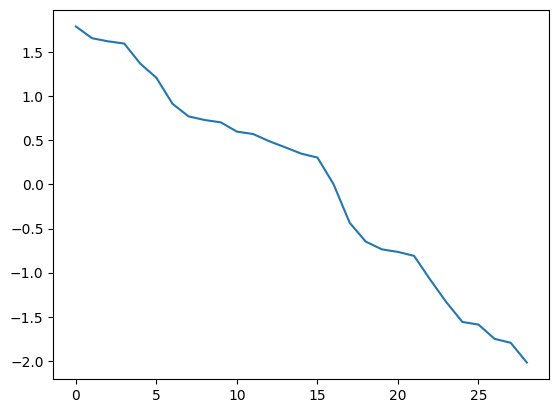

In [5]:
dirname = os.getcwd()
# head, tail = dirname.split('Ajinkya_SINDy_tests')
dir = "D:\pysindy\F1tenth_updated_filtered_data\\Clean\Test"
# dir = "D:\pysindy\Teleop_data\\filtered_teleop_data"
X_test = []
X_dot_test = []
U_test = []
T_diff_test = []

from pysindy.differentiation import SmoothedFiniteDifference # Smoothen out the data
from pysindy.differentiation import SpectralDerivative
from pysindy.differentiation import FiniteDifference
sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 10})
fd = FiniteDifference()
sd = SpectralDerivative()

diff_method = fd

for file in os.listdir(dir):
    filename = os.path.join(dir,file)
    data = spio.loadmat(filename,squeeze_me=False)
    inputs = data['updated_data']['inputs'].item()
    inputs_ts = data['updated_data']['inputs_ts'].item()
    inputs_ts = np.reshape(inputs_ts,(np.shape(inputs_ts)[0],))
    states =  data['updated_data']['states'].item()
    states_ts = data['updated_data']['states_ts'].item()
    states_ts = np.reshape(states_ts,np.shape(states_ts)[0])
    states[:,2] = np.unwrap(states[:,2]) # Unwrapping the optitrack measured angle
    delta  = inputs[:,1]; delta[delta > 0] = np.pi/6; delta[delta < 0] = -np.pi/6 # Making the steering angle transition between -30 and 30 degrees
    inputs = np.column_stack((inputs,delta))

    #Use a common time difference for all observations
    t_diff = [states_ts[i+1] - states_ts[0] for i in range(len(states_ts)-1)]
    # t_diff.insert(0,0)
    t_diff = np.array(t_diff)
    if t_diff.shape[0] > 25:
        dist = [np.sqrt((states[i,0]-states[0,0])**2 + (states[i,1]-states[0,1])**2) for i in range(1,states.shape[0])]
        dist = np.array(dist)
        # print(t_diff.shape)
        # print(dist.shape)
        # dist = np.diff(dist)
        # dist= np.insert(dist,0,0)
        # break
        # vel = np.gradient(dist,t_diff)
        vel = dist/t_diff
        vel = np.insert(vel,0,0)
        # x_dot = diff_method._differentiate(states[:,0],t_diff)
        # y_dot = diff_method._differentiate(states[:,1],t_diff)
        # theta_dot = diff_method._differentiate(states[:,2],t_diff)
        # x_dot_train_ = np.column_stack((x_dot,y_dot,theta_dot))
        # X_dot_train.append(x_dot_train_)
        x_test_ = np.column_stack((states[:,0],states[:,1],vel,states[:,2]))
        X_test.append(x_test_)
        u_test_ = np.column_stack((inputs[:,0],inputs[:,1]))
        U_test.append(u_test_)
        T_diff_test.append(t_diff)

# print(X_train[1].shape,U_train[1].shape)
print(len(X_test))
plt.plot(X_test[-1][:,0])

[Text(0, 0.5, '$\\phi$'), Text(0.5, 0, '$t$')]

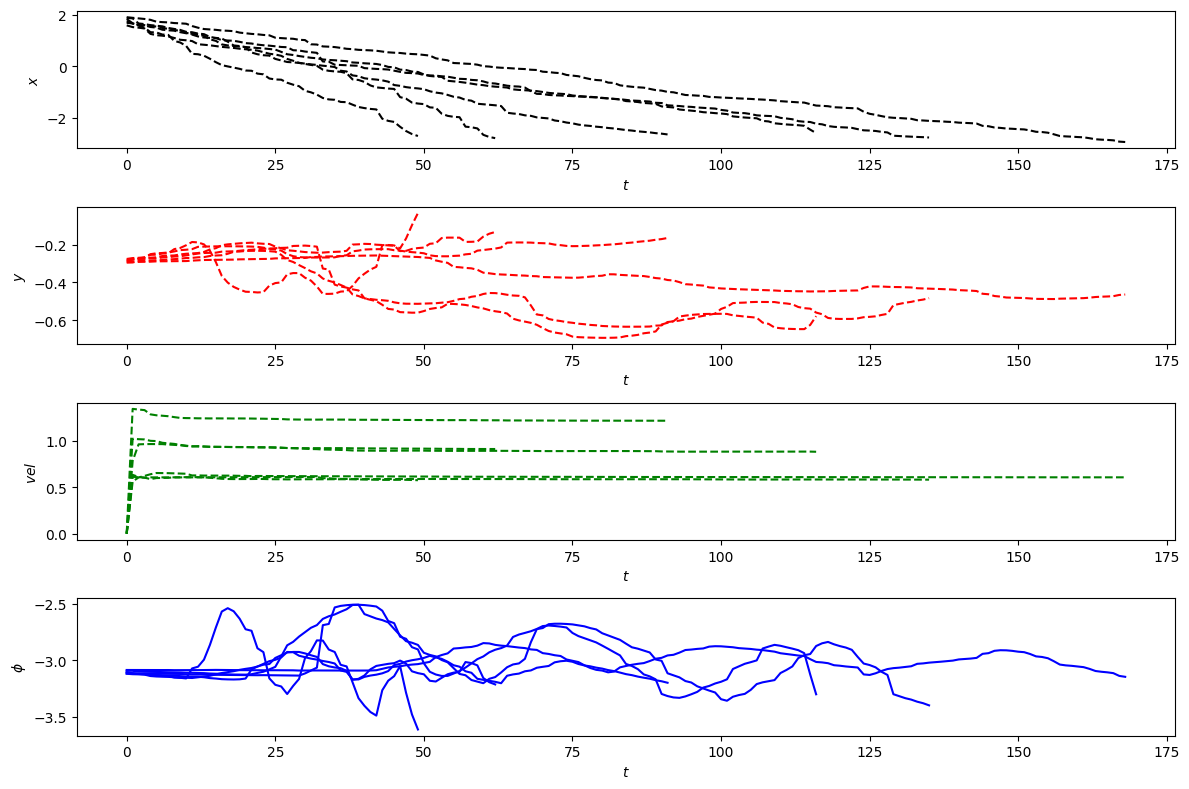

In [6]:
fig, axs = plt.subplots(4, 1, tight_layout=True, figsize=(12, 8))
for i in range(len(X_train) - 3):
    x = X_train[i][:,0]
    y = X_train[i][:,1]
    phi = X_train[i][:,3]
    vel = X_train[i][:,2]
    delta = U_train[i][:,1]
    axs[0].plot(x, '--k')
    axs[1].plot(y, '--r')
    axs[2].plot(vel, '--g')
    axs[3].plot(phi, '-b')
    # axs[4].plot(delta, 'm')
axs[0].set(
        ylabel=r'$x$',
        xlabel=r'$t$')
axs[1].set(
        ylabel=r'$y$',
        xlabel=r'$t$')
axs[2].set(
        ylabel=r'$vel$',
        xlabel=r'$t$')
axs[3].set(
        ylabel=r'$\phi$',
        xlabel=r'$t$')

In [7]:
def lift_states(X):
    # np.seterr(invalid='ignore')
    z_lift = np.zeros([15,X.shape[0]+1])
    for i in range(X.shape[0]):
        data =  X[i,:]
        x1 = data[0]
        x2 = data[1]
        x3 = data[2]
        x4 = data[3]
        t2 = np.cos(x4)
        t3 = np.sin(x4)
        t4 = x3**2
        t5 = x3**3
        t7 = x3**5
        t6 = t4**2
        t8 = np.multiply(t2,x3)
        t9 = np.multiply(t3,x3)
        t10 = np.multiply(t2,t4)
        # t11 = np.multiply(t2,t5)
        # t13 = np.multiply(t2,t7)
        t14 = np.multiply(t3,t4)
        # t15 = np.multiply(t3,t5)
        # t17 = np.multiply(t3,t7)
        # t12 = np.multiply(t2,t6)
        # t16 = np.multiply(t3,t6)
        D = np.array([1.0,x1,x2,x3,x4,t4,t5,t6,t7,t2,t3,t8,t9,t10,t14]).T
        # print(D.shape)
        z_lift[:,i] = D
        # z_lift.reshape(17,-1)
    z_lift[np.isnan(z_lift)] = 0
    return z_lift

In [8]:
def EDMD_koopman(X0,U):
    X0 = np.vstack(X0) # Vertical stack of data runs
    U0 = np.vstack(U)
    # Get temporally shifted data matrix
    X = X0[:-1,:]
    Y = X0[1:,:]

    # Lifting of states
    X_lift = lift_states(X)
    Y_lift = lift_states(Y)
    zt = X_lift
    zt_plus1 = Y_lift
    zt_control = np.row_stack((X_lift,U0.T)) # Stacking for left shifted control matrix
    print('Array shapes of zt, zt+1 and zt_control are',zt.shape,zt_plus1.shape,zt_control.shape)

    # Koopman A and B matrix by EDMD
    A_B = zt_plus1@zt_control.T@np.linalg.pinv(zt_control@zt_control.T) # Analytical solution for data snapshots
    A_edmd = np.round(A_B[:,:-2],4) # Get A matrix baring the last two columns for control matrix rounded
    B_edmd = np.round(A_B[:,-2:],4) # Get B matrix with the last two columns for control matrix rounded
    print(np.linalg.pinv(zt).shape)
    C_edmd =  np.round(X0.T@np.linalg.pinv(zt))
    return A_B,A_edmd,B_edmd, C_edmd

In [12]:
import control
from numpy import linalg as LA
AB, A_edmd, B_edmd, Cedmd =  EDMD_koopman(X_train,U_train)
print(A_edmd.shape)
w, v = LA.eig(A_edmd.T)
print(w.shape,v.shape)

eig_fns = np.dot(v,)
# X_lyap = control.lyap(A_edmd) # Lyapunov Equation

Array shapes of zt, zt+1 and zt_control are (15, 825) (15, 825) (17, 825)
(825, 15)
(15, 15)
(15,) (15, 15)


In [142]:
# Plot results
def plot_lifted_predictions(X,A,B,U,run_name,op_file_name=None):
    '''
    X is the list of trajectories
    A and B are the matrces obtained from EDMD
    U is the list of control sequences for the trajectories in X
    zt, zt_1 are the lifted X and Y matrices
    run_name is for title of the graphs indicating the type of data provided
    op_file_name is the name of the figure to be saved
    '''
    X0 = np.vstack(X)
    U = np.vstack(U)
    zt = lift_states(X0)


    traj_points = [x.shape[0] for x in X]
    traj_points.insert(0,0)
    count = 0

    fig = plt.figure(constrained_layout=True, figsize=(12, len(traj_points)*2))
    subfigs = fig.subfigures(len(traj_points), 1)
    # fig, axs = plt.subplots(len(traj_points)-1, 3, tight_layout=True, figsize=(12, 20))

    for i in range(1,len(traj_points)):
        axs = subfigs[i-1].subplots(1, 3)
        # y_lift_test = zt_1[:,traj_points[i-1]:traj_points[i]]
        x_lift_test = zt[:,count:count+traj_points[i]]
        u_test = U[count:count+traj_points[i],:].T
        y_lifted = A@x_lift_test + B@u_test
        count += traj_points[i]
        # print('Koopman prediction and data comparison for run %d'%(i))

        subfigs[i-1].suptitle('Koopman prediction and data comparison for %s %d'%(run_name,i), fontsize=16)
        axs[0].plot(y_lifted[1,:], '--r')
        axs[0].plot(X[i-1][1:,0],'b', label='X actual')
        axs[0].set_title('Predicted X v/s True value')
        axs[0].set(ylabel=r'$x$',xlabel=r'$t$')
        axs[0].legend(['X_predicted','X_actual'])

        axs[1].plot(y_lifted[2,:], '--r', label='Y predicted')
        axs[1].plot(X[i-1][1:,1],'b',label='Y actual')
        axs[1].set_title('Predicted Y v/s True value')
        axs[1].set(ylabel=r'$y$',xlabel=r'$t$')
        axs[1].legend(['Y_predicted','Y_actual'])

        axs[2].plot(y_lifted[4,:], '--r', label='Theta predicted')
        axs[2].plot(X[i-1][1:,3],'b',label='Theta actual')
        axs[2].set_title('Predicted Theta v/s True value')
        axs[2].set(ylabel=r'$\phi$',xlabel=r'$t$')
        axs[2].legend(['Theta_predicted','Theta_actual'])

    if not op_file_name== None:
        file_name = op_file_name+'.jpg'
        plt.savefig(file_name)
        print('Figure_saved')
    else:
        print('Figure name not provided for save file')





Figure name not provided for save file


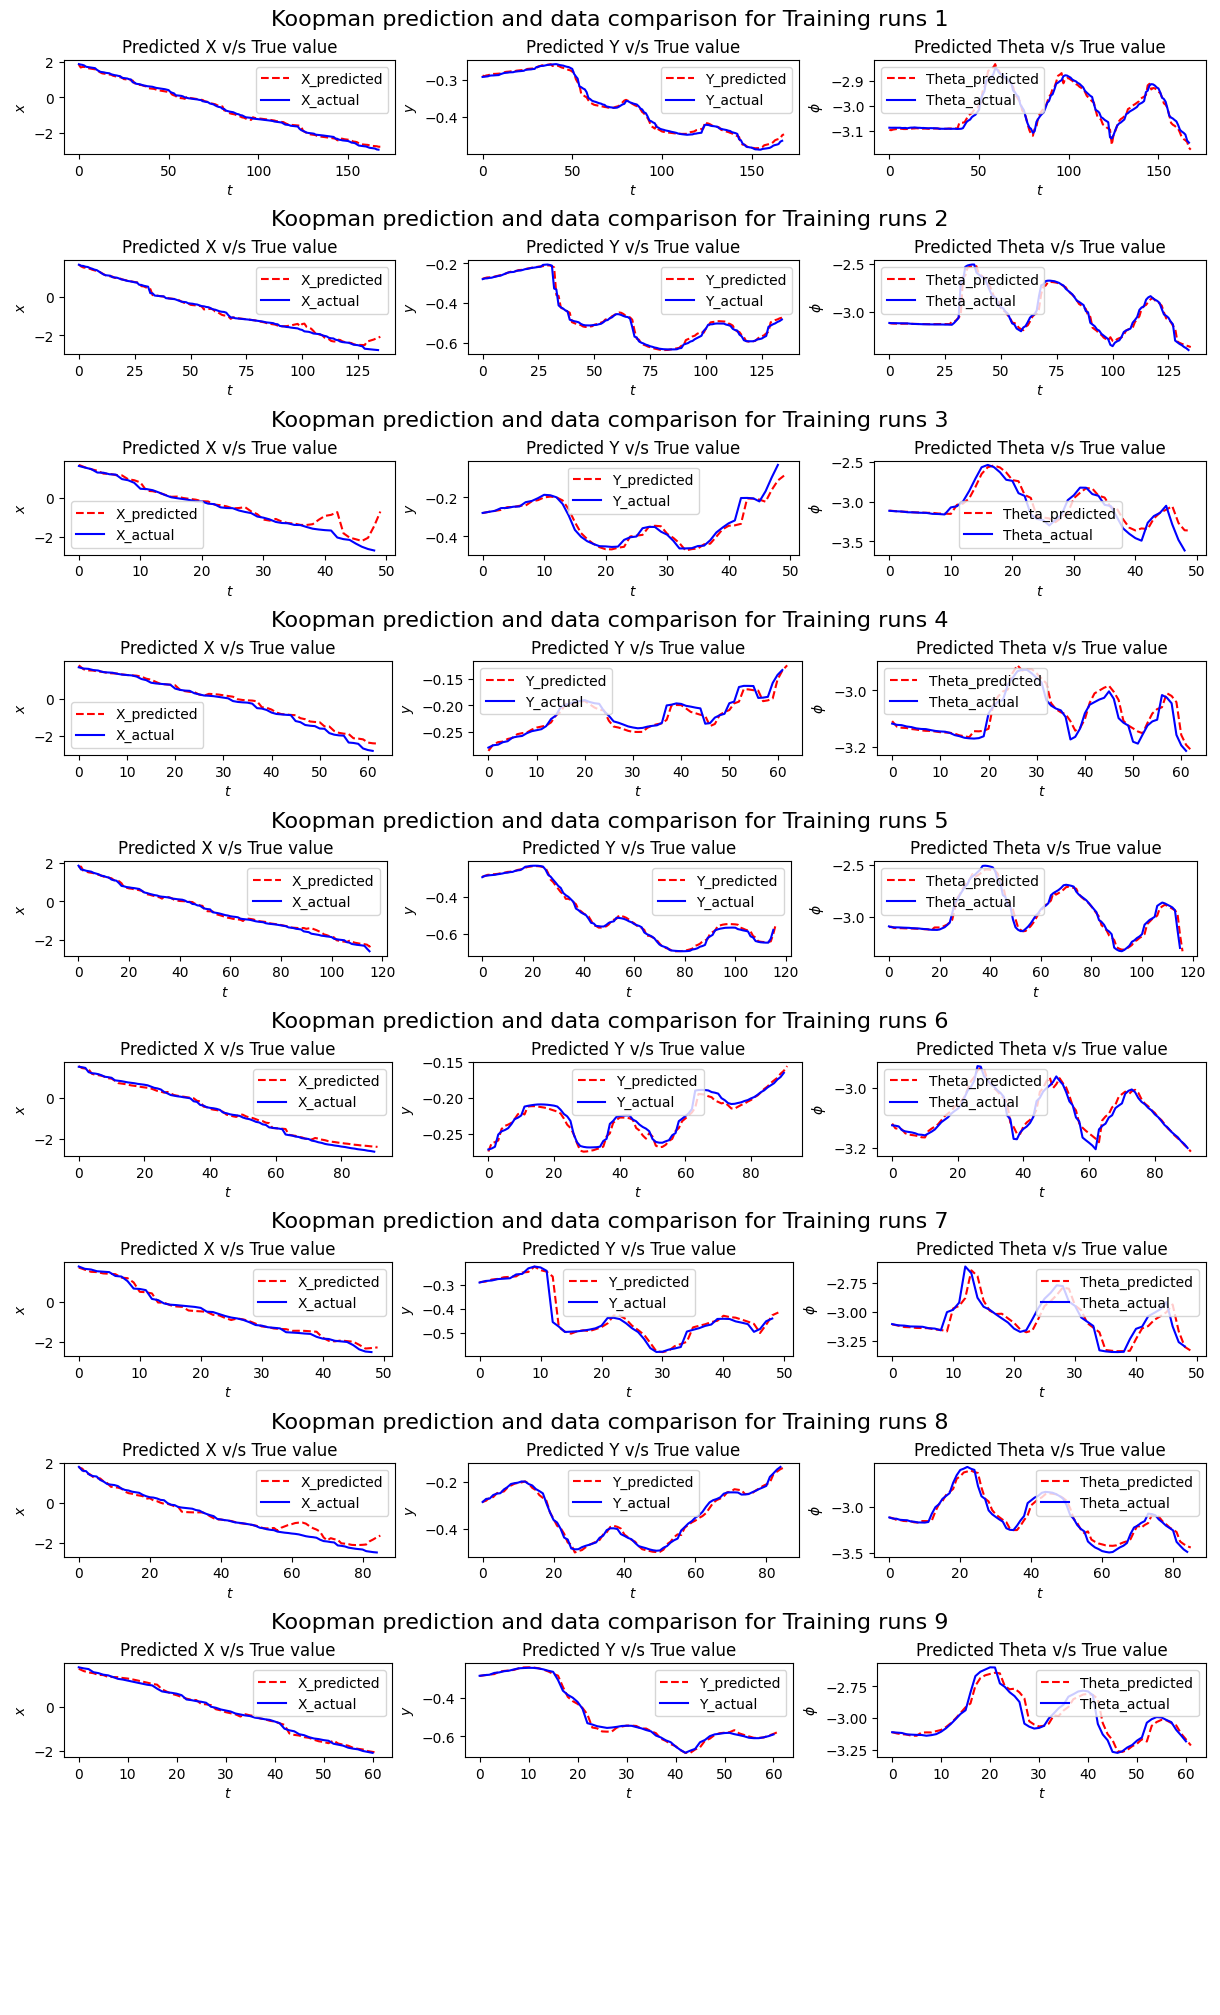

In [143]:
run_name = 'Training runs'
imsave_name = 'Koopman_slalom_noisy_training_prediction'
plot_lifted_predictions(X_train,A_edmd,B_edmd,U_train,run_name)

Figure name not provided for save file


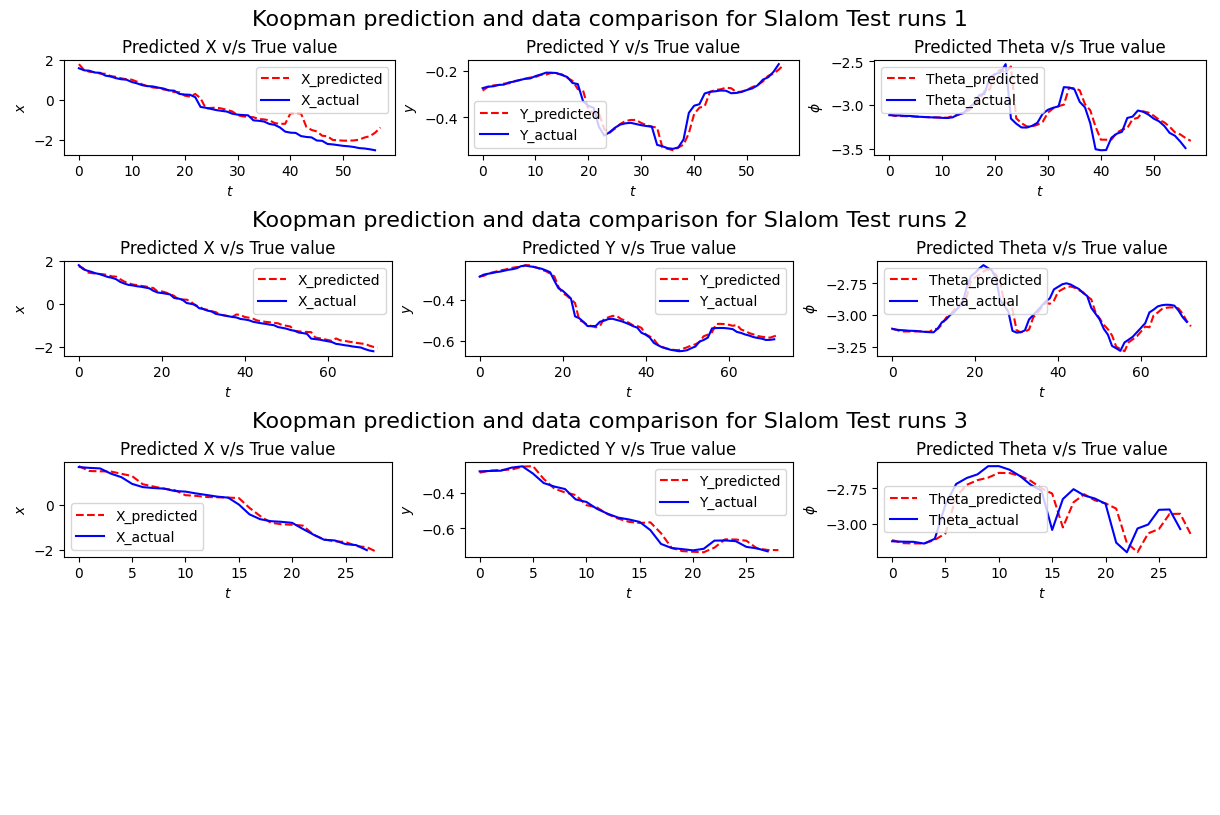

In [144]:
run_name = 'Slalom Test runs'
imsave_name = 'Koopman_slalom_noisy_testing_prediction_trained_with_noise'
plot_lifted_predictions(X_test,A_edmd,B_edmd,U_test,run_name)

In [177]:
def simulate_ol(A,B,C,X,u):
    zt = lift_states(X)
    u = u.T
    # print(u.shape)
    z_prime = np.zeros((A.shape[0],u.shape[1]))
    z_prime[:,0] = zt[:,1]
    x_hat = []
    # print(zt.shape,u.shape)
    for i in range(1,u.shape[1]):
            z_prime[:,i] = A@zt[:,i-1] + B@u[:,i-1]
            x_hat_ = C@z_prime[:,i]
            x_hat.append(x_hat_)

    x_hat = np.vstack(x_hat)

    fig, axs = plt.subplots(4, 1, tight_layout=True, figsize=(12, 8))
    # axs[0].plot(y[4,:], '--r')
    axs[0].plot(X[1:,0],'b', label='X actual')
    axs[0].plot(x_hat[:,0],'--r')
    axs[1].plot(X[1:,1],'b', label='Y actual')
    axs[1].plot(x_hat[:,1],'--r')
    axs[2].plot(X[1:,3],'b', label='Theta actual')
    axs[2].plot(x_hat[:,3],'--r')


In [56]:
simulate_ol(A_edmd,B_edmd,Cedmd,X_test[0],U_test[0])

ValueError: Expressions of dimension greater than 2 are not supported.

In [1]:
#Optimization tryouts for the AB matrix using EDMD lifting
# Import packages.
import cvxpy as cp
import numpy as np

# Generate data.

A = np.zeros((21,285),dtype=float)


# Define and solve the CVXPY problem.
A = cp.Variable(A)
cost = cp.sum_squares(zt_plus1 - A @ zt)
prob = cp.Problem(cp.Minimize(cost))
prob.solve()

# Print result.
print("\nThe optimal value is", prob.value)
print("The optimal x is")
print(A.value)
# print("The norm of the residual is ", cp.norm(A @ x - b, p=2).value)

ValueError: Expressions of dimension greater than 2 are not supported.

In [ ]:

Xs = np.randn(100,4096);
Ys = np.randn(100,300);

cvx_begin
variable Ds(300,4096)
minimize(square_pos(norm(Xs - (Ys*Ds),'fro')))
norm(Ds,'fro') <= 1
cvx_end